<a href="https://colab.research.google.com/github/rajsegar/Federated-Learning-Frameworks-/blob/main/Spam_Mail_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phishing Email Analysis using LLMs

## Introduction

This Jupyter notebook demonstrates how to use Large Language Models (LLMs) to analyze emails for potential phishing attempts. We'll use the Ollama framework to run a local LLM, then create a simple GUI for one-shot email analysis. Finally, we will test our process with a realworld datasets of phishing emails.

## Setup

Before we begin let’s import the necessary libraries: pandas, numpy, tensorflow, matplotlib, wordcloud, nltk for data processing, model building, and visualization.

In [79]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/phishing-email-dataset


# Step 1: Import Required Libraries
let’s import the necessary libraries: pandas, numpy, tensorflow, matplotlib, wordcloud, nltk for data processing, model building, and visualization.




In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Step 2: Load the Dataset
 use a dataset containing labeled emails (Spam or Ham). Let’s load the dataset and inspect its structure.

In [88]:
data = pd.read_csv('/kaggle/input/phishing-email-dataset/CEAS_08.csv')
data.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


# Setp 3 : Understand the functionality in mail_check model

In [89]:
data.info()
data['label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


,count
label,
1,21842
0,17312


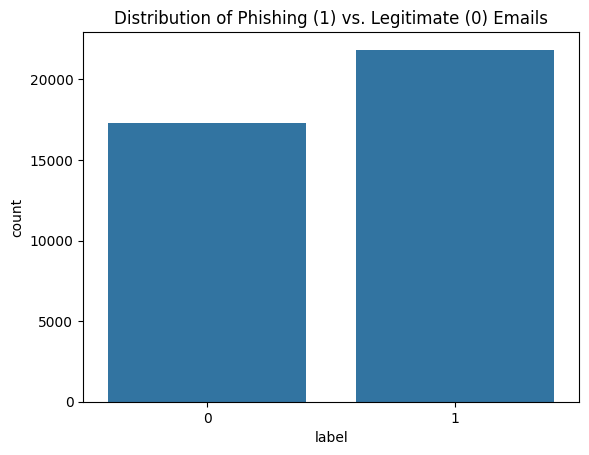

In [90]:
sns.countplot(x='label', data=data)
plt.title('Distribution of Phishing (1) vs. Legitimate (0) Emails')
plt.show()

In [92]:
data['text'] = data['subject'].str.replace('Subject', '')
data.head()

,sender,receiver,date,subject,body,label,urls,text
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,Never agree to be a loser
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,Befriend Jenna Jameson
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,CNN.com Daily Top 10
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,Re: svn commit: r619753 - in /spamassassin/tru...
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,SpecialPricesPharmMoreinfo


# Step 4: Determine Accuracy